In [1]:
!pip install xrft==0.3.0
!pip install numpy_groupies
# !pip install intake intake-xarray

  Using cached numpy_groupies-0.9.14-py3-none-any.whl


In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:41731")
client

<Client: 'tcp://127.0.0.1:41731' processes=8 threads=64, memory=235.96 GiB>

In [3]:
client.restart()

<Client: 'tcp://127.0.0.1:42933' processes=1 threads=8, memory=31.49 GiB>

In [3]:
import numpy as np
import xarray as xr
import pandas as pd
from xhistogram.xarray import histogram as xhist
from dask.diagnostics import ProgressBar
from xgcm.grid import Grid
import xrft
import gsw
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
# plt.rcParams['pcolor.shading'] = 'auto'
%matplotlib inline

In [4]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gcs://meom-ige-scratch/roxyboy'

In [5]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

# Load data

In [7]:
enatl01w = cat.eNATL60(region='1',datatype='interior_daily', season='fma').to_dask()
enatl01s = cat.eNATL60(region='1',datatype='interior_daily', season='aso').to_dask()
enatl01s

<xarray.Dataset>
Dimensions:       (deptht: 107, depthu: 107, depthv: 107, depthw: 107, time_counter: 92, x: 611, y: 763)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(15, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(15, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2009-08-01 ... 2009-10-31
Dimensions without coordinates: x, y
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(107, 15, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(1, 107, 15, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 107, 15, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 107, 15, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 107, 15, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(1, 107, 15, 611), meta=np.ndarray>

# Vorticity and strain

In [8]:
def diff(a, shift, axis):
    return a - np.roll(a, shift, axis)

def nemo_vort(u, v, e1f, e2f, e2v, e1u):
    return (
        diff(v * e2v, 1, axis=-1)
        - diff(u * e1u, 1, axis=-2)
    ) / (e1f  * e2f)

def nemo_div(u, v, e1t, e2t, e1v, e2u):
    return (
        diff(v * e1v, 1, axis=-2)
        + diff(u * e2u, 1, axis=-1)
    ) / (e1t  * e2t)

def nemo_str(u, v, e1t, e2t, e2u, e1v, e1f, e2f, e1u, e2v):
    str1 = (diff(u * e2u, 1, axis=-1)
            - diff(v * e1v, 1, axis=-2)
           ) / (e1t  * e2t)
    str2 = (diff(u * e1u, 1, axis=-2)
            + diff(v * e2v, 1, axis=-1)
           ) / (e1f  * e2f)
    str1 = .25*(str1 
                + np.roll(str1,1,-1) 
                + np.roll(str1,1,-2)
                + np.roll(np.roll(str1,1,-1),1,-2)
               )
    return np.sqrt(str1**2
        + str2**2
    )

def t_to_f(da):
    return (.25*(da 
                + np.roll(da,1,-1) 
                + np.roll(da,1,-2)
                + np.roll(np.roll(da,1,-1),1,-2)
               )
    )

In [9]:
enatlf = xr.apply_ufunc(gsw.f, enatl01w.lat, dask='parallelized')

vorenatlw = xr.apply_ufunc(
    nemo_vort,
    xr.DataArray(enatl01w.vozocrtx.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01w.time_counter.data,'deptht':enatl01w.deptht.data}), 
    xr.DataArray(enatl01w.vomecrty.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01w.time_counter.data,'deptht':enatl01w.deptht.data}), 
    enatl01w.e1f.chunk({'y':-1,'x':-1}), enatl01w.e2f.chunk({'y':-1,'x':-1}),
    enatl01w.e2v.chunk({'y':-1,'x':-1}), enatl01w.e1u.chunk({'y':-1,'x':-1}),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.vozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divenatlw = xr.apply_ufunc(
    nemo_div,
    xr.DataArray(enatl01w.vozocrtx.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01w.time_counter.data,'deptht':enatl01w.deptht.data}), 
    xr.DataArray(enatl01w.vomecrty.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01w.time_counter.data,'deptht':enatl01w.deptht.data}), 
    enatl01w.e1t.chunk({'y':-1,'x':-1}), enatl01w.e2t.chunk({'y':-1,'x':-1}),
    enatl01w.e1v.chunk({'y':-1,'x':-1}), enatl01w.e2u.chunk({'y':-1,'x':-1}),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.vozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strenatlw = xr.apply_ufunc(
    nemo_str,
    xr.DataArray(enatl01w.vozocrtx.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01w.time_counter.data,'deptht':enatl01w.deptht.data}), 
    xr.DataArray(enatl01w.vomecrty.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01w.time_counter.data,'deptht':enatl01w.deptht.data}), 
    enatl01w.e1t.chunk({'y':-1,'x':-1}), enatl01w.e2t.chunk({'y':-1,'x':-1}),
    enatl01w.e2u.chunk({'y':-1,'x':-1}), enatl01w.e1v.chunk({'y':-1,'x':-1}),
    enatl01w.e1f.chunk({'y':-1,'x':-1}), enatl01w.e2f.chunk({'y':-1,'x':-1}),
    enatl01w.e1u.chunk({'y':-1,'x':-1}), enatl01w.e2v.chunk({'y':-1,'x':-1}),
    input_core_dims = 10 * [['y', 'x']],   # 10 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01w.vozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
strenatlw

<xarray.DataArray 'strain' (time_counter: 89, deptht: 107, y: 763, x: 611)>
dask.array<transpose, shape=(89, 107, 763, 611), dtype=float32, chunksize=(3, 107, 763, 611), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
Dimensions without coordinates: y, x

In [10]:
vorenatls = xr.apply_ufunc(
    nemo_vort,
    xr.DataArray(enatl01s.vozocrtx.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01s.time_counter.data,'deptht':enatl01s.deptht.data}), 
    xr.DataArray(enatl01s.vomecrty.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01s.time_counter.data,'deptht':enatl01s.deptht.data}), 
    enatl01s.e1f.chunk({'y':-1,'x':-1}), enatl01s.e2f.chunk({'y':-1,'x':-1}),
    enatl01s.e2v.chunk({'y':-1,'x':-1}), enatl01s.e1u.chunk({'y':-1,'x':-1}),
    input_core_dims = 6 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.vozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
divenatls = xr.apply_ufunc(
    nemo_div,
    xr.DataArray(enatl01s.vozocrtx.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01s.time_counter.data,'deptht':enatl01s.deptht.data}), 
    xr.DataArray(enatl01s.vomecrty.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01s.time_counter.data,'deptht':enatl01s.deptht.data}), 
    enatl01s.e1t.chunk({'y':-1,'x':-1}), enatl01s.e2t.chunk({'y':-1,'x':-1}),
    enatl01s.e1v.chunk({'y':-1,'x':-1}), enatl01s.e2u.chunk({'y':-1,'x':-1}),
    input_core_dims = 6 * [['y', 'x']],    # 6 inputs
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.vozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('vort')
strenatls = xr.apply_ufunc(
    nemo_str,
    xr.DataArray(enatl01s.vozocrtx.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01s.time_counter.data,'deptht':enatl01s.deptht.data}), 
    xr.DataArray(enatl01s.vomecrty.chunk({'y':-1,'x':-1}).data, dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':enatl01s.time_counter.data,'deptht':enatl01s.deptht.data}), 
    enatl01s.e1t.chunk({'y':-1,'x':-1}), enatl01s.e2t.chunk({'y':-1,'x':-1}),
    enatl01s.e2u.chunk({'y':-1,'x':-1}), enatl01s.e1v.chunk({'y':-1,'x':-1}),
    enatl01s.e1f.chunk({'y':-1,'x':-1}), enatl01s.e2f.chunk({'y':-1,'x':-1}),
    enatl01s.e1u.chunk({'y':-1,'x':-1}), enatl01s.e2v.chunk({'y':-1,'x':-1}),
    input_core_dims = 10 * [['y', 'x']],
    output_core_dims = [['y', 'x']],
    output_dtypes=[enatl01s.vozocrtx.dtype],
    dask="parallelized"
).reset_coords(drop=True).rename('strain')
divenatls

,Array,Chunk
Bytes,17.10 GiB,190.29 MiB
Shape,"(92, 107, 763, 611)","(1, 107, 763, 611)"
Count,10058 Tasks,92 Chunks
Type,float32,numpy.ndarray


/tmp/ipykernel_1654/3431174883.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = ax1.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0,deptht=0)/enatlf,
/tmp/ipykernel_1654/3431174883.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im2 = ax2.pcolormesh(enatl01w.lon, enatl01w.lat, strenatlw.isel(time_counter=0,deptht=0)/enatlf,
/tmp/ipykernel_1654/3431174883.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have th

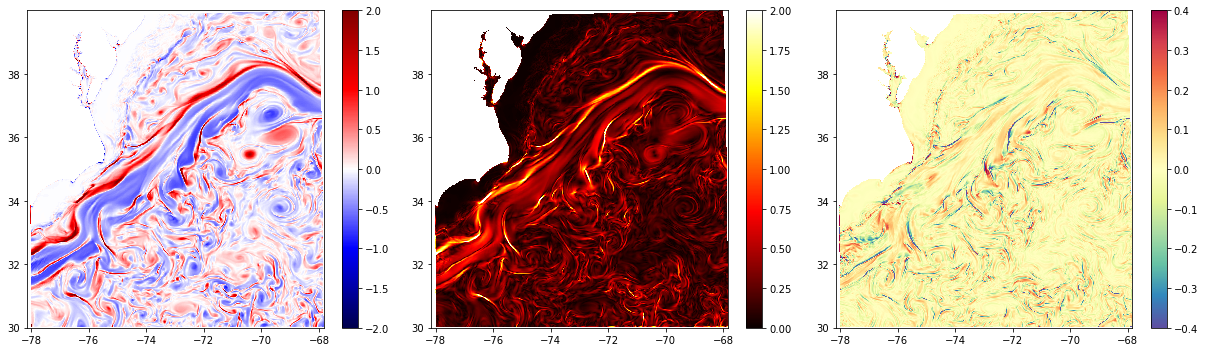

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, figsize=(17,5))
fig.set_tight_layout(True)

im1 = ax1.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0,deptht=0)/enatlf, 
                     cmap='seismic', vmax=2, vmin=-2, shading='auto', rasterized=True)
im2 = ax2.pcolormesh(enatl01w.lon, enatl01w.lat, strenatlw.isel(time_counter=0,deptht=0)/enatlf, 
                     cmap='hot', vmin=0, vmax=2, shading='auto', rasterized=True)
im3 = ax3.pcolormesh(enatl01w.lon, enatl01w.lat, divenatlw.isel(time_counter=0,deptht=0)/enatlf, 
                     cmap='Spectral_r', vmax=.4, vmin=-.4, shading='auto', rasterized=True)

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
fig.colorbar(im3, ax=ax3)

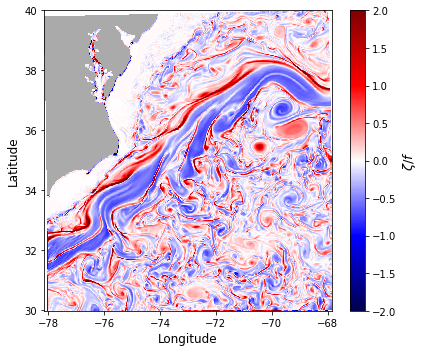

In [82]:
fig, ax = plt.subplots(figsize=(6,5))
fig.set_tight_layout(True)

ax.pcolormesh(enatl01w.lon, enatl01w.lat, np.ma.masked_invalid(vorenatlw.isel(time_counter=0)).mask, 
              cmap='binary', vmax=3, vmin=0, rasterized=True)
im = ax.pcolormesh(enatl01w.lon, enatl01w.lat, vorenatlw.isel(time_counter=0)/enatlf, 
                   cmap='seismic', vmax=2, vmin=-2, rasterized=True)

ax.set_xlabel(r"Longitude", fontsize=12)
ax.set_ylabel(r"Latitude", fontsize=12)

cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r"$\zeta/f$", fontsize=13)
plt.savefig('/home/jovyan/Figures/vort-eNATL60_01.pdf')

In [11]:
def _binned_agg(
    array: np.ndarray,
    indices: np.ndarray,
    num_bins: int,
    *,
    func,
    fill_value,
    dtype,
) -> np.ndarray:
    """NumPy helper function for aggregating over bins."""

    try:
        import numpy_groupies
    except ImportError:
        raise ImportError(
            "This function requires the `numpy_groupies` package to be installed. Please install it with pip or conda."
        )

    mask = np.logical_not(np.isnan(indices))
    int_indices = indices[mask].astype(int)
    shape = array.shape[: -indices.ndim] + (num_bins,)
    result = numpy_groupies.aggregate(
        int_indices,
        array[..., mask],
        func=func,
        size=num_bins,
        fill_value=fill_value,
        dtype=dtype,
        axis=-1,
    )
    return result


def _groupby_bins_agg(
    array: xr.DataArray,
    group: xr.DataArray,
    bins,
    func="sum",
    fill_value=0,
    dtype=None,
    **cut_kwargs,
) -> xr.DataArray:
    """Faster equivalent of Xarray's groupby_bins(...).sum()."""
    # https://github.com/pydata/xarray/issues/4473
    binned = pd.cut(np.ravel(group), bins, **cut_kwargs)
    new_dim_name = group.name + "_bins"
    indices = group.copy(data=binned.codes.reshape(group.shape))

    result = xr.apply_ufunc(
        _binned_agg,
        array,
        indices,
        input_core_dims=[indices.dims, indices.dims],
        output_core_dims=[[new_dim_name]],
        output_dtypes=[array.dtype],
        dask_gufunc_kwargs=dict(
            allow_rechunk=True,
            output_sizes={new_dim_name: binned.categories.size},
        ),
        kwargs={
            "num_bins": binned.categories.size,
            "func": func,
            "fill_value": fill_value,
            "dtype": dtype,
        },
        dask="parallelized",
    )
    result.coords[new_dim_name] = binned.categories
    return result


def isotropize(ps, fftdim, nfactor=4, **kwargs):
    """
    Isotropize a 2D power spectrum or cross spectrum
    by taking an azimuthal average.
    .. math::
        \text{iso}_{ps} = k_r N^{-1} \sum_{N} |\mathbb{F}(da')|^2
    where :math:`N` is the number of azimuthal bins.
    Parameters
    ----------
    ps : `xarray.DataArray`
        The power spectrum or cross spectrum to be isotropized.
    fftdim : list
        The fft dimensions overwhich the isotropization must be performed.
    nfactor : int, optional
        Ratio of number of bins to take the azimuthal averaging with the
        data size. Default is 4.
    """

    # compute radial wavenumber bins
    k = ps[fftdim[1]]
    l = ps[fftdim[0]]

    N = [k.size, l.size]
    nbins = int(min(N) / nfactor)
    freq_r = np.sqrt(k ** 2 + l ** 2).rename("freq_r")
    kr = _groupby_bins_agg(freq_r, freq_r, bins=nbins, func="mean")

    if "truncate" in kwargs:
        if truncate:
            if k.max() > l.max():
                kmax = l.max()
            else:
                kmax = k.max()
            kr = kr.where(kr <= kmax)
        else:
            msg = (
                "The flag `truncate` will be set to True by default in future version "
                + "in order to truncate the isotropic wavenumber larger than the "
                + "Nyquist wavenumber."
            )
            warnings.warn(msg, FutureWarning)

    iso_ps = (
        _groupby_bins_agg(ps, freq_r, bins=nbins, func="mean")
        .rename({"freq_r_bins": "freq_r"})
        .drop_vars("freq_r")
    )
    iso_ps.coords["freq_r"] = kr.data
    if "truncate" in kwargs:
        if truncate:
            return (iso_ps * iso_ps.freq_r).dropna("freq_r")
    else:
        return iso_ps * iso_ps.freq_r

In [14]:
Ny = len(enatl01w.y)
Nx = len(enatl01w.x)
dx = enatl01s.e1t.isel(y=slice(None,660),x=slice(210,None)).mean(skipna=True)
dy = enatl01s.e2t.isel(y=slice(None,660),x=slice(210,None)).mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
enatl01w_zeta = xr.DataArray((vorenatlw/enatlf.chunk({'y':-1,'x':-1})).data, dims=['time','deptht','YC','XC'],
                              coords={'time':np.arange(len(enatl01w.time_counter))*3600*24,
                                      'deptht':enatl01w.deptht.data,
                                      'YC':np.arange(0,Ny*dy,dy),
                                      'XC':np.arange(0,Nx*dx,dx)}
                             ).chunk({'deptht':1})
enatl01w_delta = xr.DataArray((divenatlw/enatlf.chunk({'y':-1,'x':-1})).data, dims=['time','deptht','YC','XC'],
                              coords={'time':np.arange(len(enatl01w.time_counter))*3600*24,
                                      'deptht':enatl01w.deptht.data,
                                      'YC':np.arange(0,Ny*dy,dy),
                                      'XC':np.arange(0,Nx*dx,dx)}
                             ).chunk({'deptht':1})
enatl01w_zeta

,Array,Chunk
Bytes,33.08 GiB,10.67 MiB
Shape,"(89, 107, 763, 611)","(3, 1, 763, 611)"
Count,7361 Tasks,3210 Chunks
Type,float64,numpy.ndarray


In [12]:
Ny = len(enatl01s.y)
Nx = len(enatl01s.x)
dx = enatl01s.e1t.isel(y=slice(None,660),x=slice(210,None)).mean(skipna=True)
dy = enatl01s.e2t.isel(y=slice(None,660),x=slice(210,None)).mean(skipna=True)

if 1/(2*dx) > 1/(2*dy):
    Kenatl = 1/(2*dy)
else:
    Kenatl = 1/(2*dx)
enatl01s_zeta = xr.DataArray(vorenatls.data, dims=['time','deptht','YC','XC'],
                          coords={'time':np.arange(len(enatl01s.time_counter))*3600*24,
                                  'deptht':enatl01s.deptht.data,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx)}
                         ).chunk({'deptht':1})
enatl01s_delta = xr.DataArray(divenatls.data, dims=['time','deptht','YC','XC'],
                          coords={'time':np.arange(len(enatl01s.time_counter))*3600*24,
                                  'deptht':enatl01s.deptht.data,
                                  'YC':np.arange(0,Ny*dy,dy),
                                  'XC':np.arange(0,Nx*dx,dx)}
                         ).chunk({'deptht':1})
enatl01s_zeta

,Array,Chunk
Bytes,17.10 GiB,1.78 MiB
Shape,"(92, 107, 763, 611)","(1, 1, 763, 611)"
Count,29746 Tasks,9844 Chunks
Type,float32,numpy.ndarray


In [15]:
Fenatlw_Z = xrft.dft(xrft.dft(enatl01w_zeta.isel(YC=slice(None,660),XC=slice(210,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatlw_Z = Fenatlw_Z.isel(freq_time=slice(len(Fenatlw_Z.freq_time)//2,None)) * 2

Fenatlw_D = xrft.dft(xrft.dft(enatl01w_delta.isel(YC=slice(None,660),XC=slice(210,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatlw_D = Fenatlw_D.isel(freq_time=slice(len(Fenatlw_D.freq_time)//2,None)) * 2

Fenatlw_D

,Array,Chunk
Bytes,18.99 GiB,6.87 MiB
Shape,"(45, 107, 660, 401)","(45, 1, 100, 100)"
Count,196983 Tasks,3745 Chunks
Type,complex128,numpy.ndarray


In [13]:
# Fenatlw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega-k-l_fma.zarr")).spectra
isoFenatlw_Z = isotropize(np.abs(Fenatlw_Z.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         )
# Fenatls_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega-k-l_aso.zarr")).spectra
isoFenatlw_D = isotropize(np.abs(Fenatlw_D.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ) 
isoFenatlw_D

NameError: name 'Fenatlw_Z' is not defined

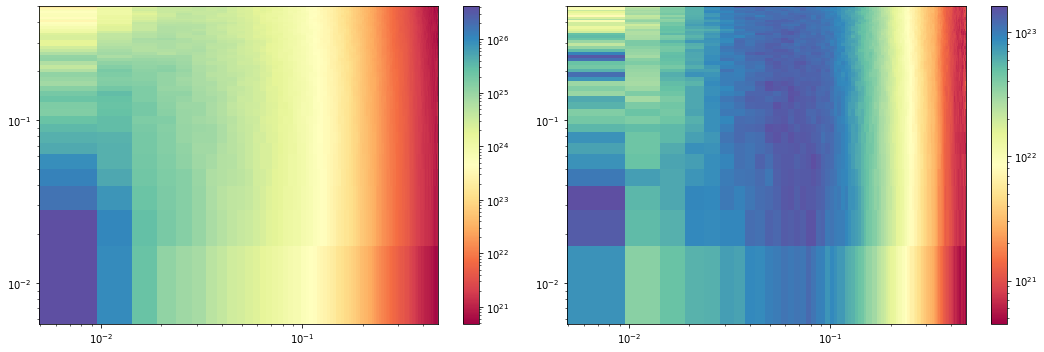

In [18]:
fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax00 = axes[0]
ax01 = axes[1]


im0 = ax00.pcolormesh(isoFenatlw_Z.freq_r.isel(freq_r=slice(1,None))*1e3,
                      isoFenatlw_Z.freq_time.isel(freq_time=slice(1,None))*86400,
                      isoFenatlw_Z.isel(freq_r=slice(1,None),freq_time=slice(1,None),deptht=43), 
                      cmap='Spectral', 
                      norm=clr.LogNorm(), 
                      shading='auto', rasterized=True)
im1 = ax01.pcolormesh(isoFenatlw_D.freq_r.isel(freq_r=slice(1,None))*1e3,
                      isoFenatlw_D.freq_time.isel(freq_time=slice(1,None))*86400,
                      isoFenatlw_D.isel(freq_r=slice(1,None),freq_time=slice(1,None),deptht=43), 
                      cmap='Spectral', 
                      norm=clr.LogNorm(), 
                      shading='auto', rasterized=True)

ax00.set_xscale('log')
ax00.set_yscale('log')
ax01.set_xscale('log')
ax01.set_yscale('log')

fig.colorbar(im0, ax=ax00)
fig.colorbar(im1, ax=ax01)

In [14]:
Fenatls_Z = xrft.dft(xrft.dft(enatl01s_zeta.isel(YC=slice(None,660),XC=slice(210,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatls_Z = Fenatls_Z.isel(freq_time=slice(len(Fenatls_Z.freq_time)//2,None)) * 2

Fenatls_D = xrft.dft(xrft.dft(enatl01s_delta.isel(YC=slice(None,660),XC=slice(210,None)).fillna(0.), 
                              dim=['YC','XC'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                             ).chunk({'time':-1,'freq_YC':100,'freq_XC':100}),
                     dim=['time'], window='hann', detrend='linear', true_phase=True, true_amplitude=True
                    )
Fenatls_D = Fenatls_D.isel(freq_time=slice(len(Fenatls_D.freq_time)//2,None)) * 2

Fenatls_D

,Array,Chunk
Bytes,19.41 GiB,7.02 MiB
Shape,"(46, 107, 660, 401)","(46, 1, 100, 100)"
Count,431228 Tasks,3745 Chunks
Type,complex128,numpy.ndarray


In [15]:
# Fenatlw_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega-k-l_fma.zarr")).spectra
isoFenatls_Z = isotropize(np.abs(Fenatls_Z.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         )
# Fenatls_H = xr.open_zarr(gcs.get_mapper(f"gcs://meom-ige-scratch/roxyboy/region01/eNATL60/SSH_omega-k-l_aso.zarr")).spectra
isoFenatls_D = isotropize(np.abs(Fenatls_D.chunk({'freq_time':10}))**2, 
                          ['freq_YC','freq_XC'], nfactor=4, kwargs={'truncate':True}
                         ) 
isoFenatls_D

<xarray.DataArray (freq_time: 46, deptht: 107, freq_r: 100)>
dask.array<mul, shape=(46, 107, 100), dtype=float64, chunksize=(10, 1, 100), chunktype=numpy.ndarray>
Coordinates:
  * deptht     (deptht) float32 0.4805 1.559 2.794 ... 968.4 985.3 1.002e+03
  * freq_time  (freq_time) float64 0.0 1.258e-07 ... 5.535e-06 5.661e-06
  * freq_r     (freq_r) float64 3.119e-06 7.255e-06 ... 0.0004655 0.0004699

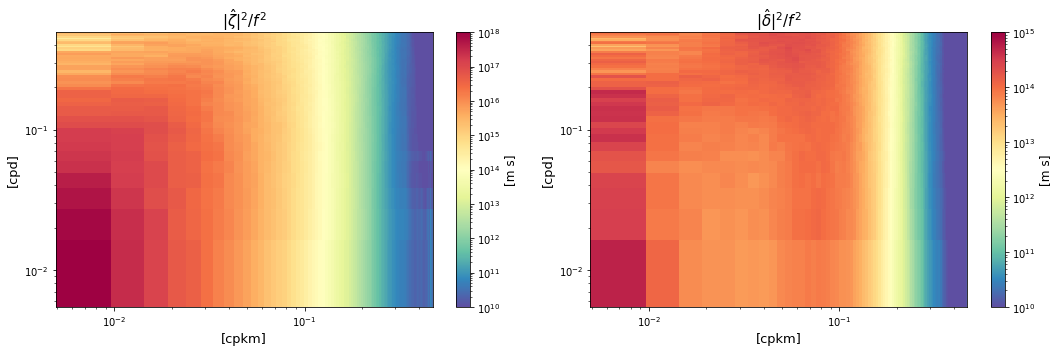

In [17]:
fig, axes = plt.subplots(figsize=(15,5), nrows=1, ncols=2)
fig.set_tight_layout(True)
ax00 = axes[0]
ax01 = axes[1]


im0 = ax00.pcolormesh(isoFenatls_Z.freq_r.isel(freq_r=slice(1,None))*1e3,
                      isoFenatls_Z.freq_time.isel(freq_time=slice(1,None))*86400,
                      isoFenatls_Z.isel(freq_r=slice(1,None),
                                        freq_time=slice(1,None)).sel(deptht=200, method='nearest'), 
                      cmap='Spectral_r', 
                      norm=clr.LogNorm(vmin=1e10, vmax=1e18), 
                      shading='auto', rasterized=True)
im1 = ax01.pcolormesh(isoFenatls_D.freq_r.isel(freq_r=slice(1,None))*1e3,
                      isoFenatls_D.freq_time.isel(freq_time=slice(1,None))*86400,
                      isoFenatls_D.isel(freq_r=slice(1,None),
                                        freq_time=slice(1,None)).sel(deptht=200, method='nearest'), 
                      cmap='Spectral_r', 
                      norm=clr.LogNorm(vmin=1e10, vmax=1e15), 
                      shading='auto', rasterized=True)

ax00.set_xscale('log')
ax00.set_yscale('log')
ax01.set_xscale('log')
ax01.set_yscale('log')

ax00.set_xlabel(r"[cpkm]", fontsize=13)
ax01.set_xlabel(r"[cpkm]", fontsize=13)
ax00.set_ylabel(r"[cpd]", fontsize=13)
ax01.set_ylabel(r"[cpd]", fontsize=13)

ax00.set_title(r"$|\hat{\zeta}|^2/f^2$", fontsize=15)
ax01.set_title(r"$|\hat{\delta}|^2/f^2$", fontsize=15)

cbar0 = fig.colorbar(im0, ax=ax00)
cbar1 = fig.colorbar(im1, ax=ax01)
cbar0.set_label(r"[m s]", fontsize=12)
cbar1.set_label(r"[m s]", fontsize=12)

In [46]:
histhycomw = xhist((strhycomw/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorhycomw/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histhycoms = xhist((strhycoms/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorhycoms/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [47]:
histfesomw = xhist((strfesomw/fesomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorfesomw/fesomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   bins=[sbins, vbins]
                  ).compute()
histfesoms = xhist((strfesoms/fesomf).rename('strain').isel(lat=slice(2,-2),
                                                            lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                   (vorfesoms/fesomf).rename('vort').isel(lat=slice(2,-2),
                                                          lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                   bins=[sbins, vbins]
                  ).compute()

In [48]:
histllcw = xhist((strllcw/llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                       i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 (vorllcw/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                 bins=[sbins, vbins]
                ).compute()
histllcs = xhist((strllcs/llcfG).rename('strain').isel(j_g=slice(2,-2),
                                                       i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),
                 (vorllcs/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                     i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}),  
                 bins=[sbins, vbins]
                ).compute()

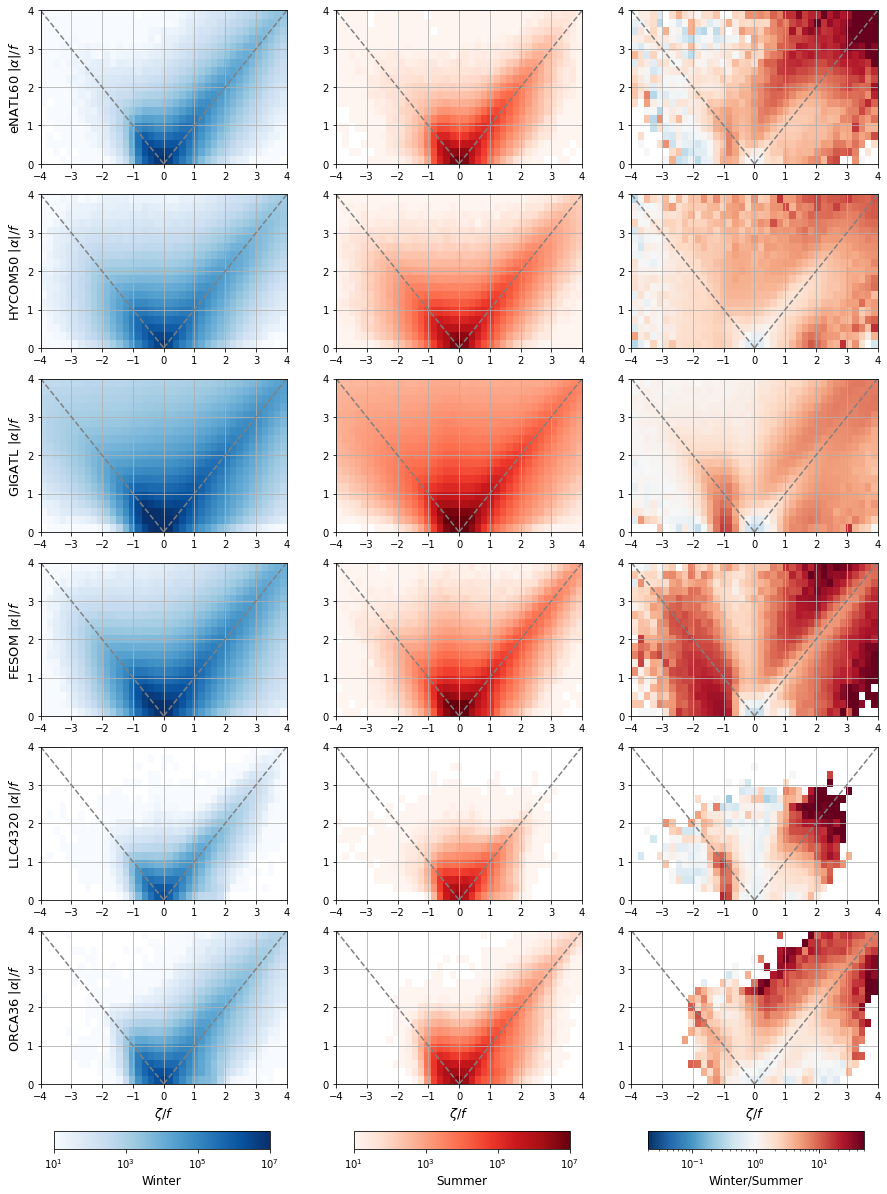

In [55]:
fig, axes = plt.subplots(figsize=(15,21), nrows=6, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]
ax40 = axes[4,0]
ax41 = axes[4,1]
ax42 = axes[4,2]
ax50 = axes[5,0]
ax51 = axes[5,1]
ax52 = axes[5,2]


im0 = ax00.pcolormesh(histenatlw.vort_bin,
                      histenatlw.strain_bin,
                      histenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                      rasterized=True, shading='auto')
ax10.pcolormesh(histhycomw.vort_bin,
                histhycomw.strain_bin,
                histhycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax20.pcolormesh(histgigatlw.vort_bin,
                histgigatlw.strain_bin,
                histgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax30.pcolormesh(histfesomw.vort_bin,
                histfesomw.strain_bin,
                histfesomw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax40.pcolormesh(histllcw.vort_bin,
                histllcw.strain_bin,
                histllcw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax50.pcolormesh(historcaw.vort_bin,
                historcaw.strain_bin,
                historcaw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')

im1 = ax01.pcolormesh(histenatls.vort_bin,
                      histenatls.strain_bin,
                      histenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                      rasterized=True, shading='auto')
ax11.pcolormesh(histhycoms.vort_bin,
                histhycoms.strain_bin,
                histhycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax21.pcolormesh(histgigatls.vort_bin,
                histgigatls.strain_bin,
                histgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax31.pcolormesh(histfesoms.vort_bin,
                histfesoms.strain_bin,
                histfesoms,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax41.pcolormesh(histllcs.vort_bin,
                histllcs.strain_bin,
                histllcs,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')
ax51.pcolormesh(historcas.vort_bin,
                historcas.strain_bin,
                historcas,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e1, vmax=1e7),
                rasterized=True, shading='auto')

im2 = ax02.pcolormesh(histenatlw.vort_bin,
                      histenatlw.strain_bin, 
                      (histenatlw
                       / histenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                      rasterized=True, shading='auto')
ax12.pcolormesh(histhycomw.vort_bin,
                histhycomw.strain_bin, 
                (histhycomw
                 / histhycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax22.pcolormesh(histgigatlw.vort_bin,
                histgigatlw.strain_bin, 
                (histgigatlw
                 / histgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax32.pcolormesh(histfesomw.vort_bin,
                histfesomw.strain_bin, 
                (histfesomw
                 / histfesoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax42.pcolormesh(histllcw.vort_bin,
                histllcw.strain_bin, 
                (histllcw
                 / histllcs), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')
ax52.pcolormesh(historcaw.vort_bin,
                historcaw.strain_bin, 
                (historcaw
                 / historcas), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True, shading='auto')


ax00.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax01.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax02.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax10.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax11.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax12.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax20.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax21.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax22.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax30.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax31.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax32.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax40.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax40.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax41.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax41.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax42.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax42.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax50.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax50.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax51.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax51.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
ax52.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
ax52.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-4,4])
ax01.set_xlim([-4,4])
ax02.set_xlim([-4,4])
ax10.set_xlim([-4,4])
ax11.set_xlim([-4,4])
ax12.set_xlim([-4,4])
ax20.set_xlim([-4,4])
ax21.set_xlim([-4,4])
ax22.set_xlim([-4,4])
ax30.set_xlim([-4,4])
ax31.set_xlim([-4,4])
ax32.set_xlim([-4,4])
ax40.set_xlim([-4,4])
ax41.set_xlim([-4,4])
ax42.set_xlim([-4,4])
ax50.set_xlim([-4,4])
ax51.set_xlim([-4,4])
ax52.set_xlim([-4,4])
ax00.set_ylim([0,4])
ax01.set_ylim([0,4])
ax02.set_ylim([0,4])
ax10.set_ylim([0,4])
ax11.set_ylim([0,4])
ax12.set_ylim([0,4])
ax20.set_ylim([0,4])
ax21.set_ylim([0,4])
ax22.set_ylim([0,4])
ax30.set_ylim([0,4])
ax31.set_ylim([0,4])
ax32.set_ylim([0,4])
ax40.set_ylim([0,4])
ax41.set_ylim([0,4])
ax42.set_ylim([0,4])
ax50.set_ylim([0,4])
ax51.set_ylim([0,4])
ax52.set_ylim([0,4])

ax50.set_xlabel(r"$\zeta/f$", fontsize=13)
ax51.set_xlabel(r"$\zeta/f$", fontsize=13)
ax52.set_xlabel(r"$\zeta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $|\alpha|/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $|\alpha|/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $|\alpha|/f$", fontsize=13)
ax30.set_ylabel(r"FESOM $|\alpha|/f$", fontsize=13)
ax40.set_ylabel(r"LLC4320 $|\alpha|/f$", fontsize=13)
ax50.set_ylabel(r"ORCA36 $|\alpha|/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)
ax40.grid(True)
ax41.grid(True)
ax42.grid(True)
ax50.grid(True)
ax51.grid(True)
ax52.grid(True)

fig.subplots_adjust(bottom=.17, hspace=.2) 
cbax0 = fig.add_axes([0.137, 0.127, 0.2, 0.012])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.127, 0.2, 0.012])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.687, 0.127, 0.2, 0.012])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/vort-strain-jointPDF_01.pdf')

In [37]:
dbins = np.linspace(-1e0,1e0,40)

In [38]:
dhistenatlw = xhist((t_to_f(divenatlw)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    (vorenatlw/enatlf).rename('vort').isel(y=slice(2,-2),
                                                           x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    bins=[dbins, vbins]
                   ).compute()
dhistenatls = xhist((t_to_f(divenatls)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}),  
                    (vorenatls/enatlf).rename('vort').isel(y=slice(2,-2),
                                                           x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    bins=[dbins, vbins]
                   ).compute()

In [39]:
dhistgigatlw = xhist((gridg.interp(gridg.interp(divgigaw,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                     (vorgigaw/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                          xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[dbins, vbins]
                    ).compute()
dhistgigatls = xhist((gridg.interp(gridg.interp(divgigas,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),  
                     (vorgigas/gigaf).rename('vort').isel(eta_v=slice(2,-2),
                                                          xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[dbins, vbins]
                    ).compute()

In [40]:
dhisthycomw = xhist((t_to_f(divhycomw)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    (vorhycomw/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                           lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),
                    bins=[dbins, vbins]
                   ).compute()
dhisthycoms = xhist((t_to_f(divhycoms)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),  
                    (vorhycoms/hycomf).rename('vort').isel(lat=slice(2,-2),
                                                           lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),
                    bins=[dbins, vbins]
                   ).compute()

In [ ]:
dhistllcw = xhist((gridllc.interp(gridllc.interp(divllcw,'X',boundary='extend'),'Y',boundary='extend')
                   / llcfG).rename('div').isel(j_g=slice(2,-2),
                                               i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  (vorllcw/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                      i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  bins=[dbins, vbins]
                 ).compute()
dhistllcs = xhist((gridllc.interp(gridllc.interp(divllcs,'X',boundary='extend'),'Y',boundary='extend')
                   / llcfG).rename('div').isel(j_g=slice(2,-2),
                                               i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  (vorllcs/llcfG).rename('vort').isel(j_g=slice(2,-2),
                                                      i_g=slice(2,-2)).chunk({'time':10,'j_g':-1,'i_g':-1}), 
                  bins=[dbins, vbins]
                 ).compute()

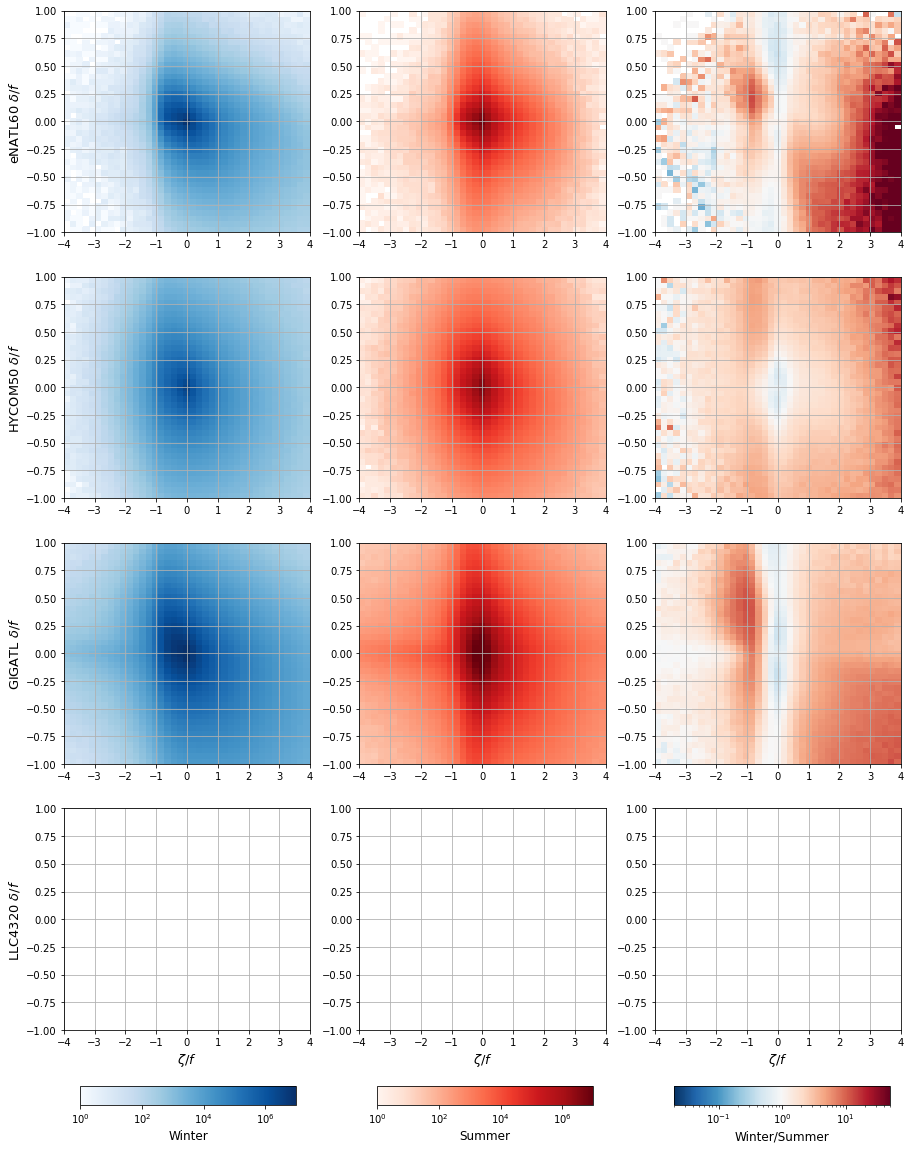

In [42]:
fig, axes = plt.subplots(figsize=(15,20), nrows=4, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]


im0 = ax00.pcolormesh(dhistenatlw.vort_bin,
                      dhistenatlw.div_bin,
                      dhistenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax10.pcolormesh(dhisthycomw.vort_bin,
                dhisthycomw.div_bin,
                dhisthycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax20.pcolormesh(dhistgigatlw.vort_bin,
                dhistgigatlw.div_bin,
                dhistgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax30.pcolormesh(dhistllcw.vort_bin,
#                 dhistllcw.div_bin,
#                 dhistllcw,
#                 cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im1 = ax01.pcolormesh(dhistenatls.vort_bin,
                      dhistenatls.div_bin,
                      dhistenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax11.pcolormesh(dhisthycoms.vort_bin,
                dhisthycoms.div_bin,
                dhisthycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax21.pcolormesh(dhistgigatls.vort_bin,
                dhistgigatls.div_bin,
                dhistgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax31.pcolormesh(histllcs.vort_bin,
#                 histllcs.div_bin,
#                 histllcs,  
#                 cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im2 = ax02.pcolormesh(dhistenatlw.vort_bin,
                      dhistenatlw.div_bin, 
                      (dhistenatlw
                       / dhistenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                      rasterized=True)
ax12.pcolormesh(dhisthycomw.vort_bin,
                dhisthycomw.div_bin, 
                (dhisthycomw
                 / dhisthycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
ax22.pcolormesh(dhistgigatlw.vort_bin,
                dhistgigatlw.div_bin, 
                (dhistgigatlw
                 / dhistgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
# ax32.pcolormesh(histllcw.vort_bin,
#                 histllcw.div_bin, 
#                 (histllcw
#                  / histllcs), 
#                 cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
#                 rasterized=True)


# ax00.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax01.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax02.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax10.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax11.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax12.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax20.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax21.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax22.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax30.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax31.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax32.plot(np.linspace(-4,4,5),np.linspace(-.4,.4,5),c='grey',ls='--')
# # ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-4,4])
ax01.set_xlim([-4,4])
ax02.set_xlim([-4,4])
ax10.set_xlim([-4,4])
ax11.set_xlim([-4,4])
ax12.set_xlim([-4,4])
ax20.set_xlim([-4,4])
ax21.set_xlim([-4,4])
ax22.set_xlim([-4,4])
ax30.set_xlim([-4,4])
ax31.set_xlim([-4,4])
ax32.set_xlim([-4,4])
ax00.set_ylim([-1,1])
ax01.set_ylim([-1,1])
ax02.set_ylim([-1,1])
ax10.set_ylim([-1,1])
ax11.set_ylim([-1,1])
ax12.set_ylim([-1,1])
ax20.set_ylim([-1,1])
ax21.set_ylim([-1,1])
ax22.set_ylim([-1,1])
ax30.set_ylim([-1,1])
ax31.set_ylim([-1,1])
ax32.set_ylim([-1,1])

ax30.set_xlabel(r"$\zeta/f$", fontsize=13)
ax31.set_xlabel(r"$\zeta/f$", fontsize=13)
ax32.set_xlabel(r"$\zeta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $\delta/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $\delta/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $\delta/f$", fontsize=13)
ax30.set_ylabel(r"LLC4320 $\delta/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.172, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.12, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.12, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.12, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/vort-div-jointPDF_01.pdf')

In [47]:
shistenatlw = xhist((strenatlw/enatlf).rename('strain').isel(y=slice(2,-2),
                                                             x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                    (t_to_f(divenatlw)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                    bins=[sbins, dbins]
                   ).compute()
shistenatls = xhist((strenatls/enatlf).rename('strain').isel(y=slice(2,-2),
                                                             x=slice(2,-2)).chunk({'y':-1,'x':-1}), 
                    (t_to_f(divenatls)/enatlf).rename('div').isel(y=slice(2,-2),
                                                                  x=slice(2,-2)).chunk({'y':-1,'x':-1}),
                    bins=[sbins, dbins]
                   ).compute()

In [49]:
shistgigatlw = xhist((strgigaw/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                            xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                     (gridg.interp(gridg.interp(divgigaw,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[sbins, dbins]
                    ).compute()
shistgigatls = xhist((strgigas/gigaf).rename('strain').isel(eta_v=slice(2,-2),
                                                            xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}), 
                     (gridg.interp(gridg.interp(divgigas,'xi'),'eta')
                      / gigaf).rename('div').isel(eta_v=slice(2,-2),
                                                  xi_u=slice(2,-2)).chunk({'eta_v':-1,'xi_u':-1}),
                     bins=[sbins, dbins]
                    ).compute()

In [50]:
shisthycomw = xhist((strhycomw/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                             lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    (t_to_f(divhycomw)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    bins=[sbins, dbins]
                   ).compute()
shisthycoms = xhist((strhycoms/hycomf).rename('strain').isel(lat=slice(2,-2),
                                                             lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}), 
                    (t_to_f(divhycoms)/hycomf).rename('div').isel(lat=slice(2,-2),
                                                                  lon=slice(2,-2)).chunk({'lat':-1,'lon':-1}),
                    bins=[sbins, dbins]
                   ).compute()

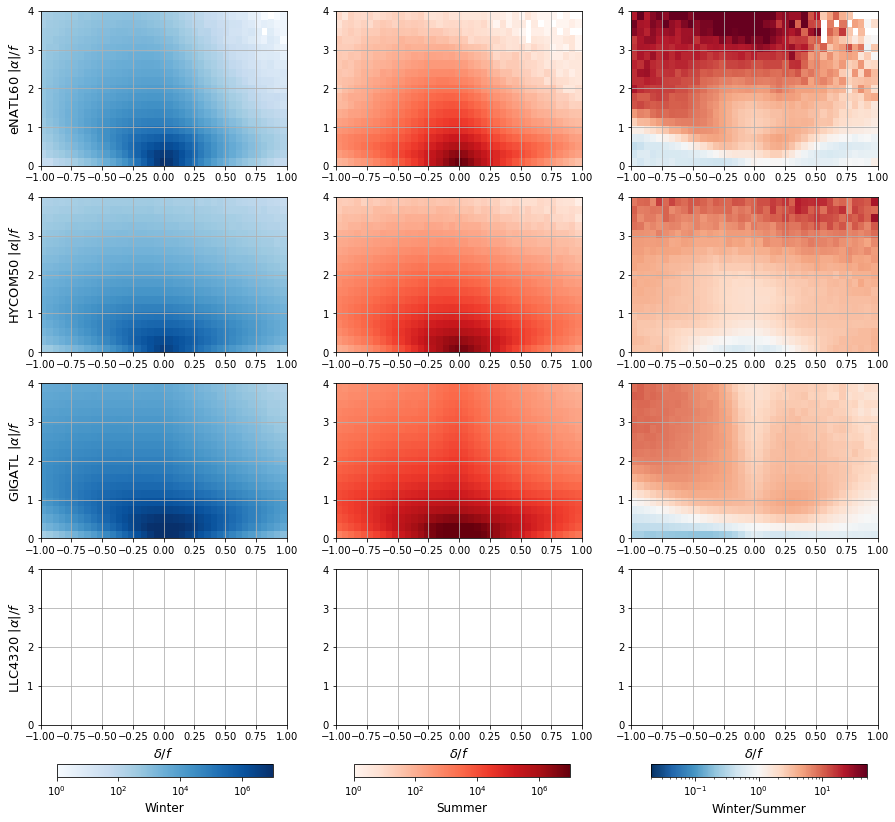

In [51]:
fig, axes = plt.subplots(figsize=(15,14), nrows=4, ncols=3)
# fig.set_tight_layout(True)
ax00 = axes[0,0]
ax01 = axes[0,1]
ax02 = axes[0,2]
ax10 = axes[1,0]
ax11 = axes[1,1]
ax12 = axes[1,2]
ax20 = axes[2,0]
ax21 = axes[2,1]
ax22 = axes[2,2]
ax30 = axes[3,0]
ax31 = axes[3,1]
ax32 = axes[3,2]


im0 = ax00.pcolormesh(shistenatlw.div_bin,
                      shistenatlw.strain_bin,
                      shistenatlw, 
                      cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax10.pcolormesh(shisthycomw.div_bin,
                shisthycomw.strain_bin,
                shisthycomw, 
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax20.pcolormesh(shistgigatlw.div_bin,
                shistgigatlw.strain_bin,
                shistgigatlw,
                cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax30.pcolormesh(histllcw.vort_bin,
#                 histllcw.strain_bin,
#                 histllcw,
#                 cmap='Blues', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im1 = ax01.pcolormesh(shistenatls.div_bin,
                      shistenatls.strain_bin,
                      shistenatls,
                      cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                      rasterized=True)
ax11.pcolormesh(shisthycoms.div_bin,
                shisthycoms.strain_bin,
                shisthycoms,
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
ax21.pcolormesh(shistgigatls.div_bin,
                shistgigatls.strain_bin,
                shistgigatls,  
                cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
                rasterized=True)
# ax31.pcolormesh(histllcs.vort_bin,
#                 histllcs.strain_bin,
#                 histllcs,  
#                 cmap='Reds', norm=clr.LogNorm(vmin=1e0, vmax=1e7),
#                 rasterized=True)

im2 = ax02.pcolormesh(shistenatlw.div_bin,
                      shistenatlw.strain_bin, 
                      (shistenatlw
                       / shistenatls), 
                      cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                      rasterized=True)
ax12.pcolormesh(shisthycomw.div_bin,
                shisthycomw.strain_bin, 
                (shisthycomw
                 / shisthycoms), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
ax22.pcolormesh(shistgigatlw.div_bin,
                shistgigatlw.strain_bin, 
                (shistgigatlw
                 / shistgigatls), 
                cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
                rasterized=True)
# ax32.pcolormesh(histllcw.vort_bin,
#                 histllcw.strain_bin, 
#                 (histllcw
#                  / histllcs), 
#                 cmap='RdBu_r', norm=clr.LogNorm(vmin=2e-2, vmax=5e1), 
#                 rasterized=True)


# ax00.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax00.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax01.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax01.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax02.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax02.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax10.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax10.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax11.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax11.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax12.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax12.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax20.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax20.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax21.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax21.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax22.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax22.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax30.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax30.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax31.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax31.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')
# ax32.plot(np.linspace(0,4,5),np.linspace(0,4,5),c='grey',ls='--')
# ax32.plot(np.linspace(-4,0,5),np.linspace(4,0,5),c='grey',ls='--')


ax00.set_xlim([-1,1])
ax01.set_xlim([-1,1])
ax02.set_xlim([-1,1])
ax10.set_xlim([-1,1])
ax11.set_xlim([-1,1])
ax12.set_xlim([-1,1])
ax20.set_xlim([-1,1])
ax21.set_xlim([-1,1])
ax22.set_xlim([-1,1])
ax30.set_xlim([-1,1])
ax31.set_xlim([-1,1])
ax32.set_xlim([-1,1])
ax00.set_ylim([0,4])
ax01.set_ylim([0,4])
ax02.set_ylim([0,4])
ax10.set_ylim([0,4])
ax11.set_ylim([0,4])
ax12.set_ylim([0,4])
ax20.set_ylim([0,4])
ax21.set_ylim([0,4])
ax22.set_ylim([0,4])
ax30.set_ylim([0,4])
ax31.set_ylim([0,4])
ax32.set_ylim([0,4])

ax30.set_xlabel(r"$\delta/f$", fontsize=13)
ax31.set_xlabel(r"$\delta/f$", fontsize=13)
ax32.set_xlabel(r"$\delta/f$", fontsize=13)
ax00.set_ylabel(r"eNATL60 $|\alpha|/f$", fontsize=13)
ax10.set_ylabel(r"HYCOM50 $|\alpha|/f$", fontsize=13)
ax20.set_ylabel(r"GIGATL $|\alpha|/f$", fontsize=13)
ax30.set_ylabel(r"LLC4320 $|\alpha|/f$", fontsize=13)

ax00.grid(True)
ax01.grid(True)
ax02.grid(True)
ax10.grid(True)
ax11.grid(True)
ax12.grid(True)
ax20.grid(True)
ax21.grid(True)
ax22.grid(True)
ax30.grid(True)
ax31.grid(True)
ax32.grid(True)

fig.subplots_adjust(bottom=.172, hspace=.2) 
cbax0 = fig.add_axes([0.14, 0.12, 0.2, 0.013])
cbar0 = fig.colorbar(im0, orientation='horizontal', cax=cbax0)
cbar0.set_label(r"Winter", fontsize=12)

cbax1 = fig.add_axes([0.415, 0.12, 0.2, 0.013])
cbar1 = fig.colorbar(im1, orientation='horizontal', cax=cbax1)
cbar1.set_label(r"Summer", fontsize=12)

cbax2 = fig.add_axes([0.69, 0.12, 0.2, 0.013])
cbar2 = fig.colorbar(im2, orientation='horizontal', cax=cbax2)
cbar2.set_label(r"Winter/Summer", fontsize=12)

plt.savefig('/home/jovyan/Figures/div-strain-jointPDF_01.pdf')

In [ ]:
client.close()